Calibrate MPU and output adjusted log.

In [82]:
import matplotlib.pylab as pylab
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pylab.rcParams['figure.figsize'] = 12, 12

def from_space_separated(file):
    log = []
    with open(file, 'r', encoding='latin-1') as f:
        for line in f:
            parts = line.split(' ')
            try:
                # ax,ay,az,gx,gy,gz,dt_s,y,p,r
                ax = parts[0]
                ay = parts[1]
                az = parts[2]
                gx = parts[3]
                gy = parts[4]
                gz = parts[5]
                dt = parts[6]
                y = parts[7]
                p = parts[8]
                r = parts[9]
                log.append(np.array([ax, ay, az, gx, gy, gz, y, p, r, dt]).astype(np.float))
            except Exception as e:
                print('lol, err: {}'.format(e))
    return np.array(log)

log = from_space_separated('calibration_and_pose.txt')
log_time = np.cumsum(log[:, 9])

Use first six seconds to estimate gyro biases and noise levels.

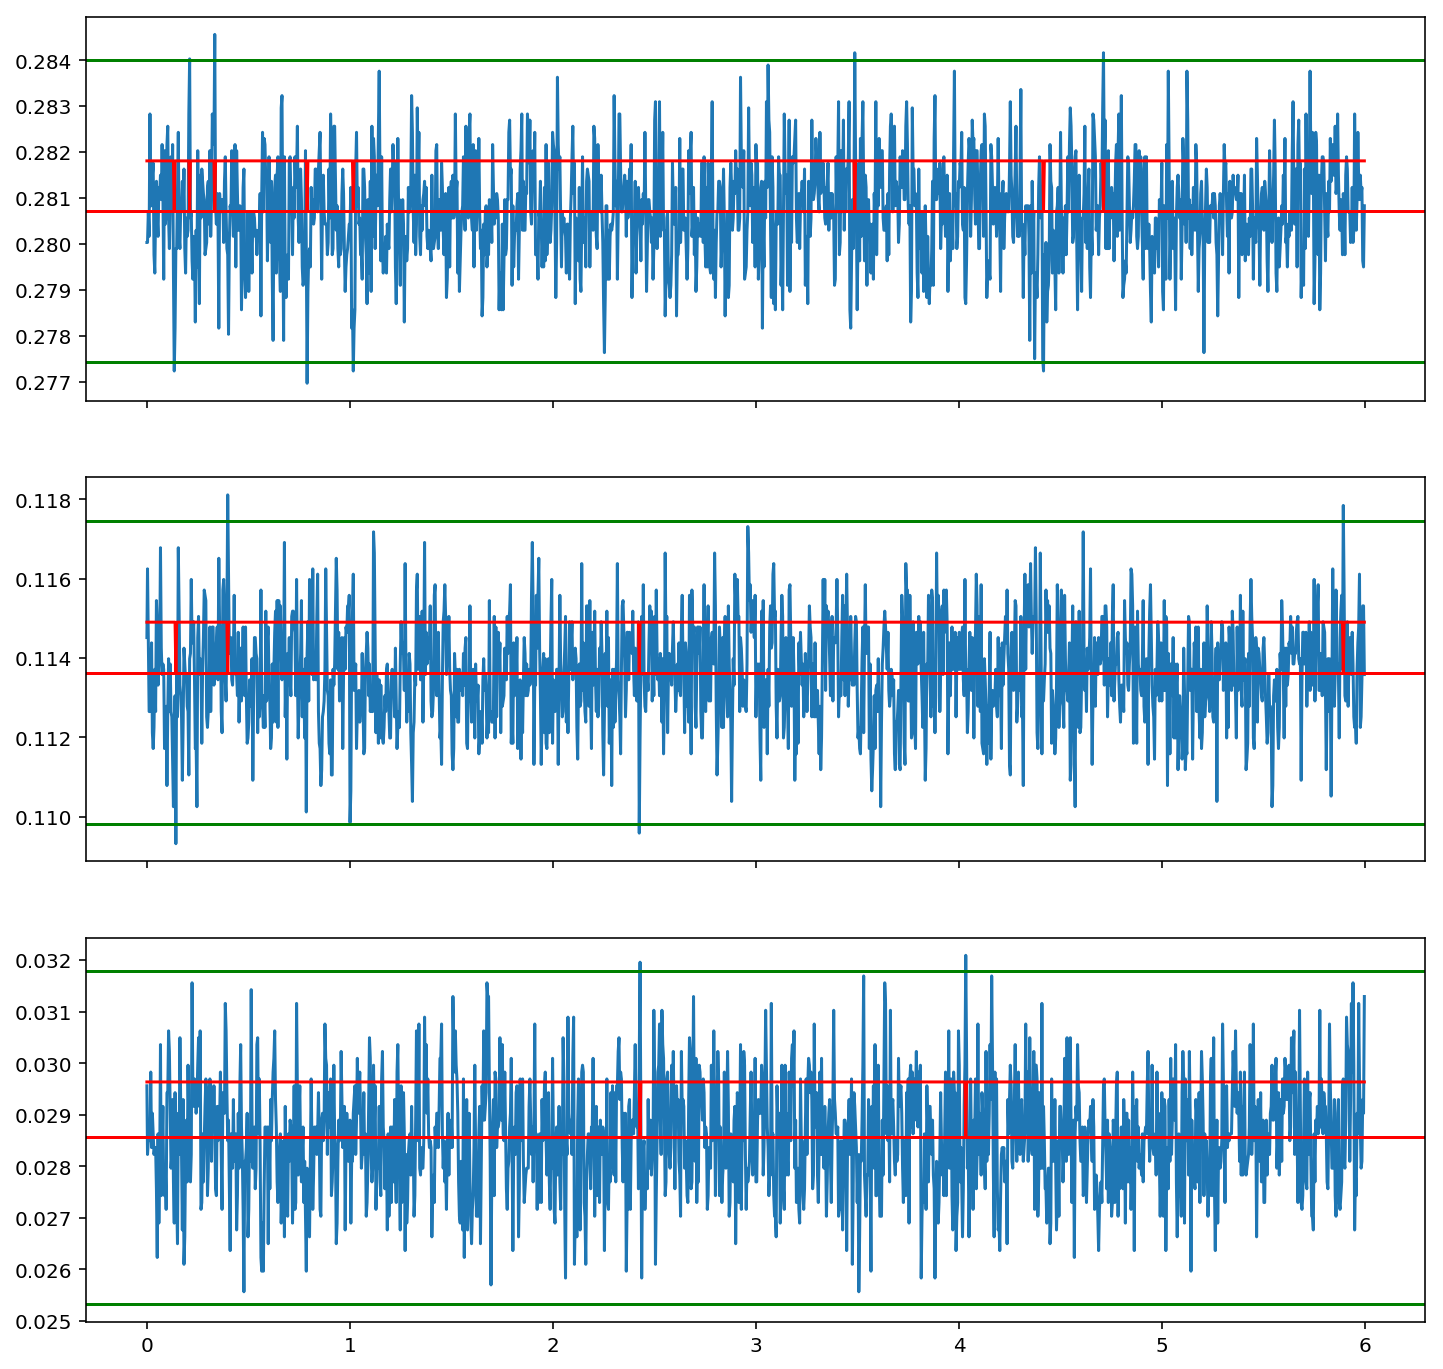

In [88]:
def plot_multi(log, cols, time=None):
    f, axarr = plt.subplots(len(cols), sharex=True)
    for i, c in enumerate(cols):
        if not time is None:
            axarr[i].plot(time, log[:, c])
        else:
            axarr[i].plot(log[:, c])
    return f, axarr

noise_time = 6
noise_log = log[log_time < noise_time, :]
_, axarr = plot_multi(noise_log, [3, 4, 5], time=log_time[log_time < noise_time])

stdevs = []
means = []
for i, c in enumerate([3, 4, 5]):
    std = np.std(noise_log[:, c])
    mean = np.mean(noise_log[:, c])
    axarr[i].axhline(mean, c = 'red')
    axarr[i].axhline(mean + 3 * std, c = 'green')
    axarr[i].axhline(mean - 3 * std, c = 'green')
    axarr[i].plot(log_time[log_time < noise_time], (np.abs(noise_log[:, c] - mean) < std * 3) * std + mean, c = 'red')
    stdevs.append(std)
    means.append(mean)

Given noise estimates find still ranges.

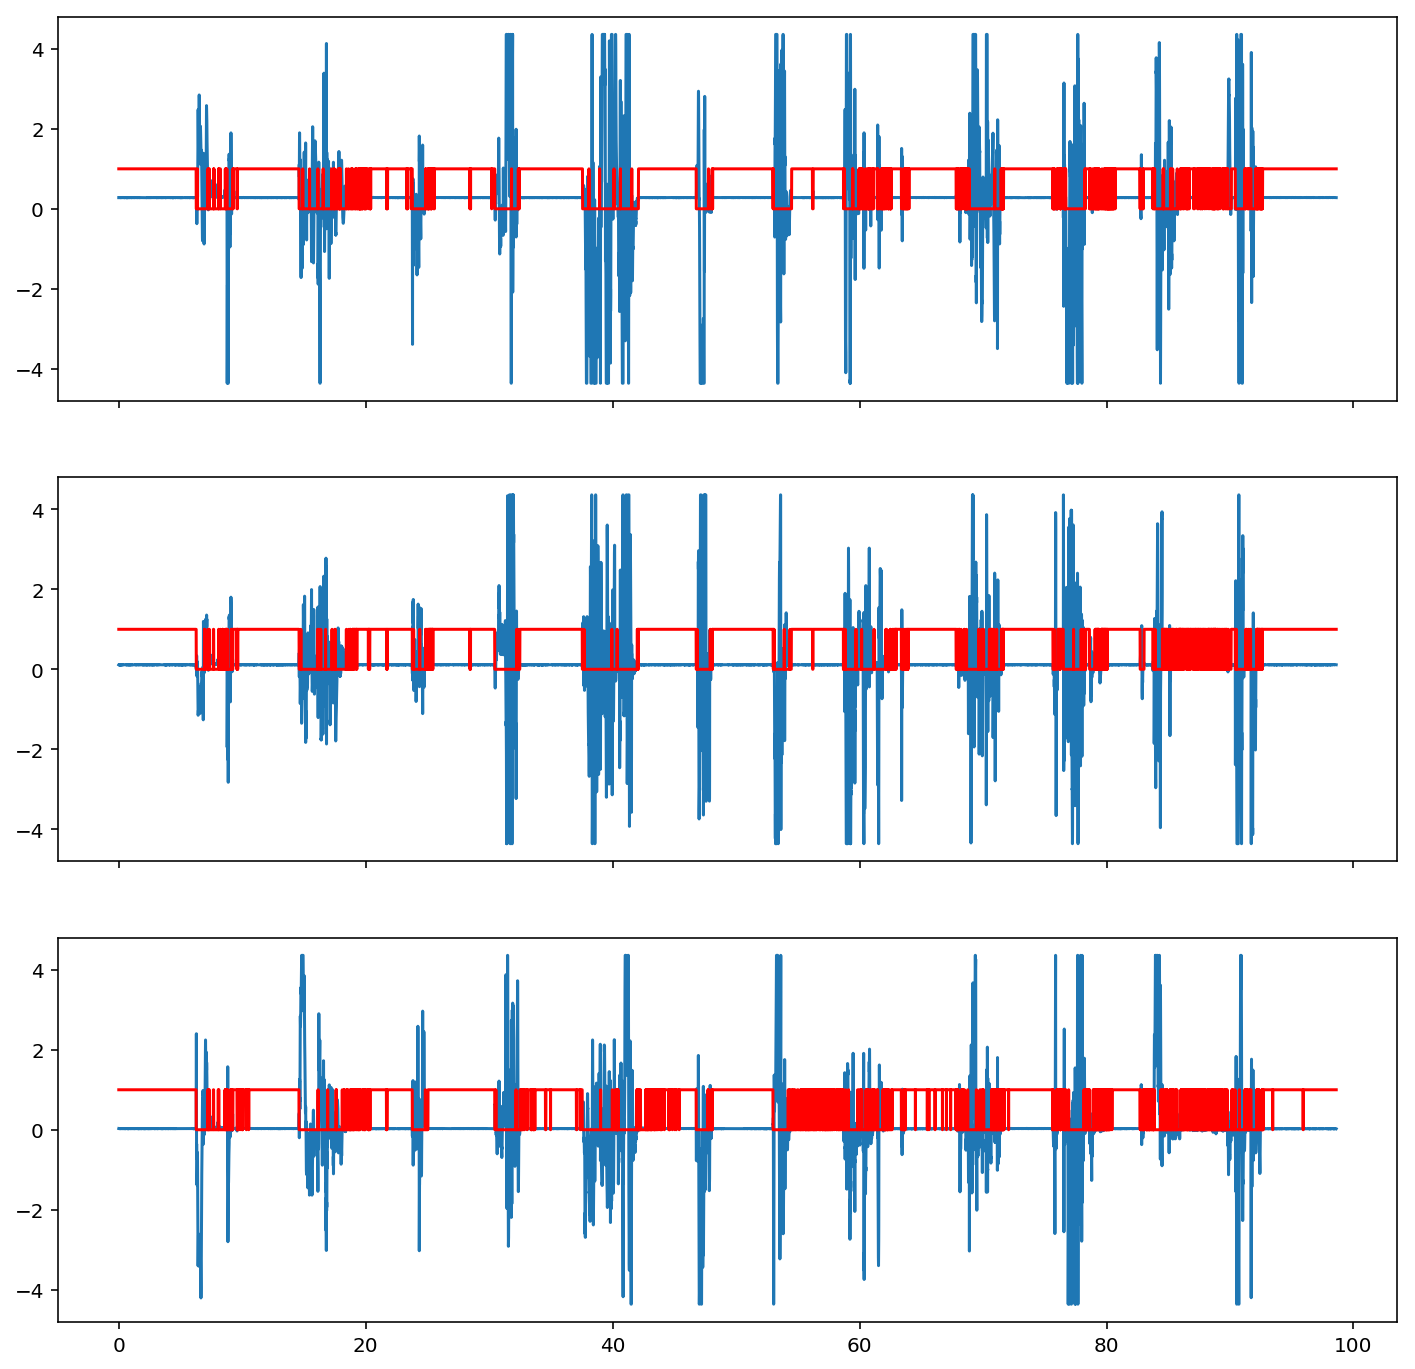

In [115]:
_, axarr = plot_multi(log, [3, 4, 5], time=log_time)

stills = []
for i, c in enumerate([3, 4, 5]):
    std = stdevs[i]
    mean = means[i]
    axarr[i].plot(log_time, np.abs(log[:, c] - mean) < std * 5, c = 'red')
    stills.append(np.abs(log[:, c] - mean) < std * 5)
    stdevs.append(std)
    means.append(mean)

stills = np.array(stills)

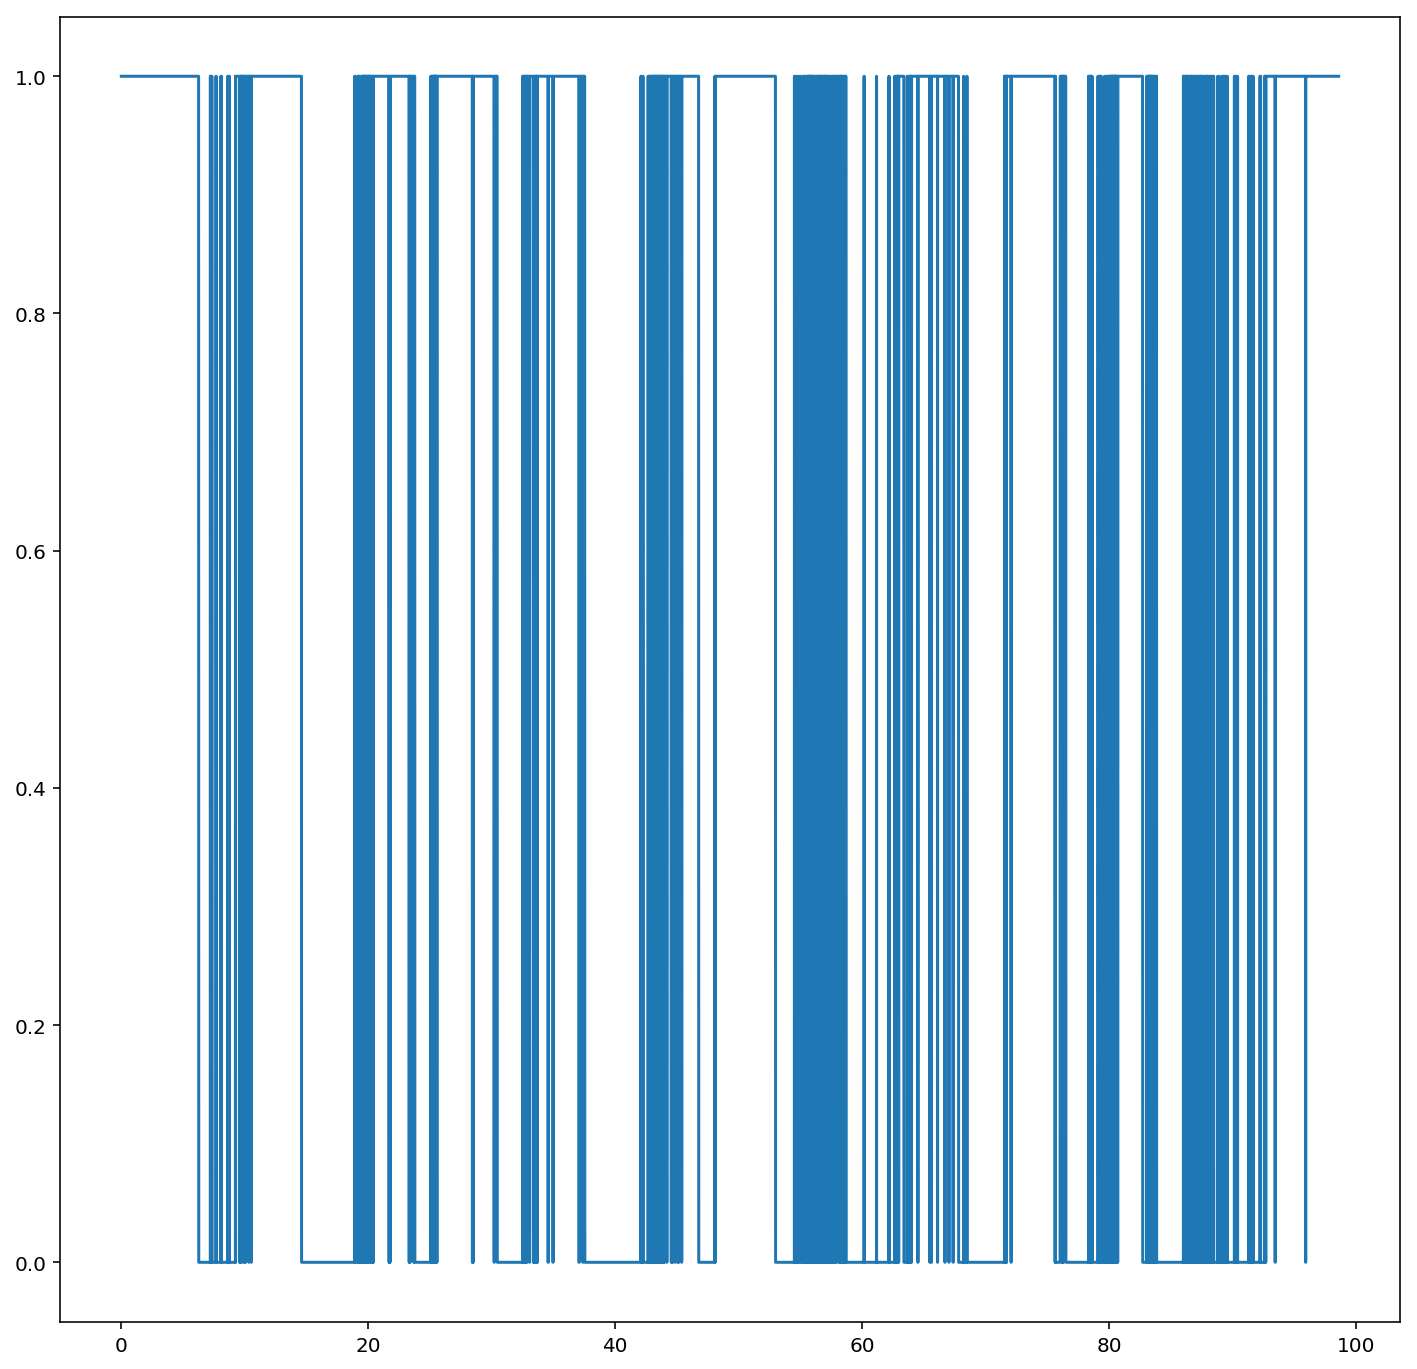

In [113]:
plt.plot(log_time, np.all(stills, axis=0))